Processing file: D:/48_QPC2_Gatesweep (01)/Time 1,E+0arb, units (01).dat
Processing file: D:/48_QPC2_Gatesweep (01)/Time 2,E+0arb, units (01).dat


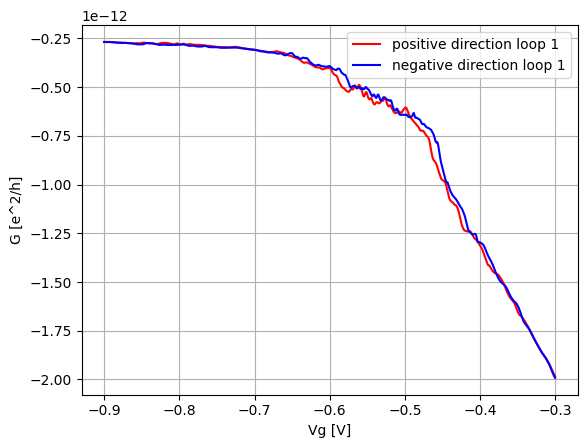

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.constants import e, h
import tkinter as tk
from tkinter import filedialog

def load_data(file_path, encoding='latin1'):
    with open(file_path, 'r', encoding=encoding) as file:
        lines = file.readlines()

    metadata = {}
    data_start_line = None
    for i, line in enumerate(lines):
        if line.strip() == '---------':
            data_start_line = i + 2
            break
        key_value = line.split(':', 1)
        if len(key_value) == 2:
            key, value = key_value
            metadata[key.strip()] = value.strip()

    if data_start_line is None:
        raise ValueError("Data start line not found")

    step_value = None
    for line in lines:
        if "Step value:" in line:
            step_value = line.split(":")[1].strip()
            break
    metadata["Step value"] = step_value

    data_lines = lines[data_start_line:]
    data = []
    for line in data_lines:
        split_line = line.strip().split()
        if len(split_line) == 16:
            try:
                data.append([float(val) for val in split_line])
            except ValueError:
                print(f"Skipping line due to ValueError: {line}")
                continue

    if len(data) == 0:
        print("No valid data found after parsing.")
        raise ValueError("No valid data found")

    df = pd.DataFrame(data, columns=[
        'VDC', 'Time', 'Temperature_K', 'Temperature_Ohm', 'Magnet', 
        'DCV_Agilent_Ch1', 'DCV_Keysight1_Ch1', 'DCV_Keysight2_Ch1', 
        'DCV_Keysight3_Ch1', 'DCV_Agilent_Ch2', 'DCV_Keysight1_Ch2', 
        'Empty1', 'R1', 'G1', 'R2', 'G2'
    ])
    return df, metadata

def plot_conductance(positive_data, negative_data, output_dir):
    plt.figure()
    
    # Plot positive direction data
    for i, data in enumerate(positive_data):
        voltage = data['VDC']
        conductance = (data['DCV_Agilent_Ch1'] / 1e12) / (voltage / 1000) * (2 * e**2 / h)
        plt.plot(voltage, conductance, label=f'positive direction {i+1}', color='red')

    # Plot negative direction data
    for i, data in enumerate(negative_data):
        voltage = data['VDC']
        conductance = (data['DCV_Agilent_Ch1'] / 1e12) / (voltage / 1000) * (2 * e**2 / h)
        plt.plot(voltage, conductance, label=f'negative direction {i+1}', color='blue')

    plt.xlabel('Vg [V]')
    plt.ylabel('G [e^2/h]')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'conductance_vs_voltage.png'))
    plt.show()

def main():
    root = tk.Tk()
    root.withdraw()  # Hide the root window

    # File picker
    filelist = filedialog.askopenfilenames(parent=root, filetypes=[('Data files', '*.dat')])
    if not filelist:
        raise ValueError("No files selected")

    # Directory picker
    output_dir = filedialog.askdirectory(parent=root, title="Select Output Directory")
    if not output_dir:
        raise ValueError("No output directory selected")
    
    root.destroy() 

    positive_data = []
    negative_data = []

    for file_path in filelist:
        print(f"Processing file: {file_path}")
        data, metadata = load_data(file_path)
        
        if data['VDC'].iloc[0] > data['VDC'].iloc[-1]:
            negative_data.append(data)
        else:
            positive_data.append(data)

    plot_conductance(positive_data, negative_data, output_dir)

if __name__ == "__main__":
    main()
